In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm

In [2]:
parameter_dict = {
    "test_id": "filtered-strict-subsample-001", 
    "do_regress_out": True,
    "do_combat": False,
    "n_neighbors": [50],
    "n_pcs": [15],
    "cluster_resolution": [.5, 1, 1.5, 2],
}

In [3]:
# base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
base_path = 'Z:/Data/Analyzed/2024-01-08-Jiakun-MouseSpleen64Gene/'
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
test_path = os.path.join(output_path, parameter_dict['test_id'])
if not os.path.exists(test_path):
    os.mkdir(test_path)
    
cdata = sc.read_h5ad(os.path.join(expr_path, f'combined-filtered-strict-subsample-001.h5ad'))

# pp 
sc.pp.normalize_total(cdata)
sc.pp.log1p(cdata)
cdata.raw = cdata
sc.pp.scale(cdata)
cdata.layers['scaled'] = cdata.X.copy()

In [4]:
if parameter_dict['do_regress_out']:
    sc.pp.regress_out(cdata, ['total_counts'])
    cdata.layers['corrected'] = cdata.X.copy()

if parameter_dict['do_combat']:   
    sc.pp.combat(cdata, 'sample')
    cdata.layers['combat'] = cdata.X.copy()

C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [5]:
cdata

AnnData object with n_obs × n_vars = 18335 × 64
    obs: 'sample', 'fov_id', 'volume', 'fov_x', 'fov_y', 'fov_z', 'seg_label', 'global_x', 'global_y', 'global_z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes'
    var: 'mean', 'std'
    uns: 'log1p'
    layers: 'raw', 'scaled', 'corrected'

In [6]:
# add condition 
cdata.obs['condition'] = cdata.obs['sample'].values
condition_dict = {
    'sample1': 'WT',
    'sample2': "WT",
    'sample3': "99R",
    'sample4': '99R',
    'sample5': '33NM',
    'sample6': '33NM'
}
cdata.obs['condition'] = cdata.obs['condition'].map(condition_dict)
cdata.obs['condition'] = cdata.obs['condition'].astype('category')
cdata.obs['sample'] = cdata.obs['sample'].astype('category')
cdata.obs['sample'].value_counts()

sample4    4067
sample3    3735
sample5    3342
sample1    2964
sample6    2525
sample2    1702
Name: sample, dtype: int64

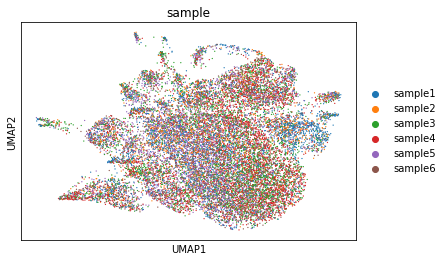

In [38]:
# pca
sc.tl.pca(cdata, svd_solver='full')
sc.pp.neighbors(cdata, n_neighbors=50, n_pcs=15)

# umap
sc.tl.umap(cdata, min_dist=.5, spread=2)
sc.pl.umap(cdata, color='sample',)

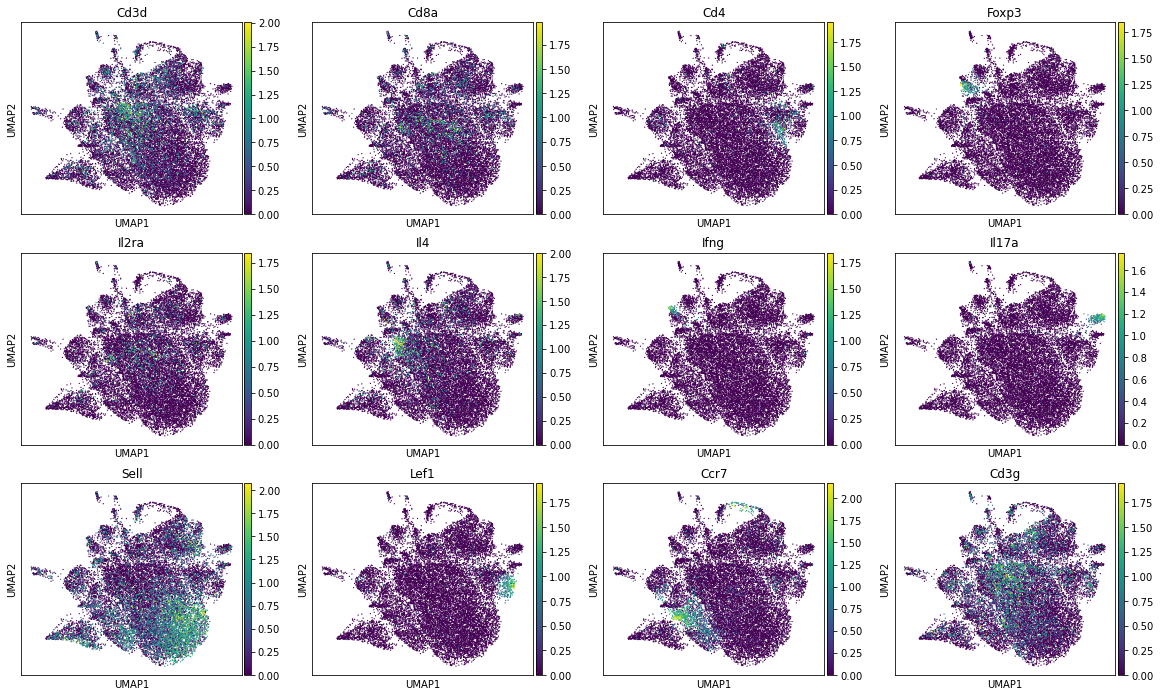

In [39]:
t_cell_genes = ['Cd3d', 'Cd8a', 'Cd4', 'Foxp3', 'Il2ra', 'Il4', 'Ifng', 'Il17a', 'Sell', 'Lef1', 'Ccr7', 'Cd3g']

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(20, 12))
axs = axs.flatten()

for i, current_gene in enumerate(t_cell_genes):
    sc.pl.umap(cdata, color=current_gene, ax=axs[i], show=False)

plt.show()

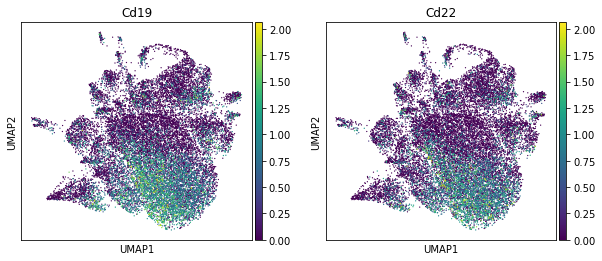

In [43]:
b_cell_genes = ['Cd19', 'Cd22']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
axs = axs.flatten()

for i, current_gene in enumerate(b_cell_genes):
    sc.pl.umap(cdata, color=current_gene, ax=axs[i], show=False)

plt.show()

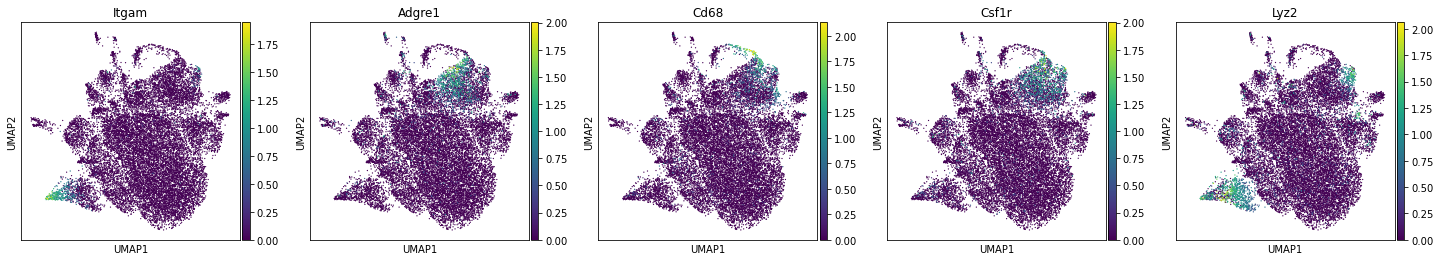

In [44]:
macro_cell_genes = ['Itgam', 'Adgre1', 'Cd68', 'Csf1r', 'Lyz2']

fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(25, 4))
axs = axs.flatten()

for i, current_gene in enumerate(macro_cell_genes):
    sc.pl.umap(cdata, color=current_gene, ax=axs[i], show=False)

plt.show()

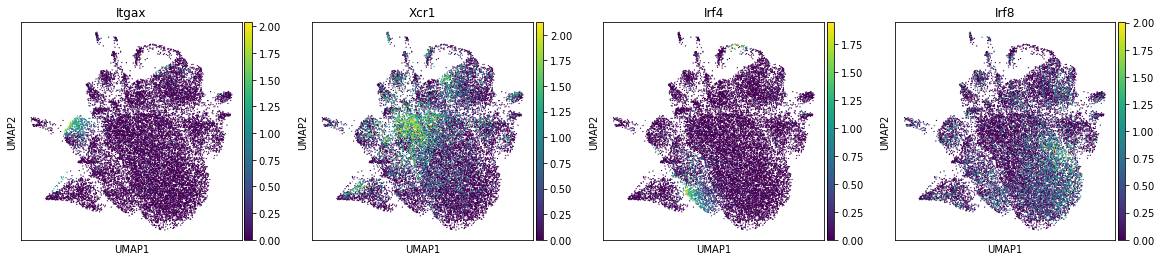

In [42]:
dendri_cell_genes = ['Itgax', 'Xcr1', 'Irf4', 'Irf8']

fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(20, 4))
axs = axs.flatten()

for i, current_gene in enumerate(dendri_cell_genes):
    sc.pl.umap(cdata, color=current_gene, ax=axs[i], show=False)

plt.show()

## Level 1

### clustering

In [64]:
# leiden clustering
sc.tl.leiden(cdata, resolution=1)

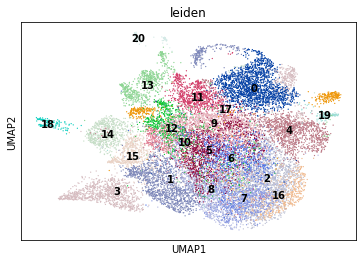

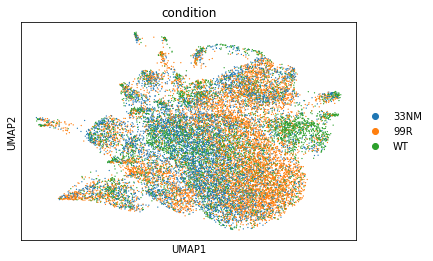

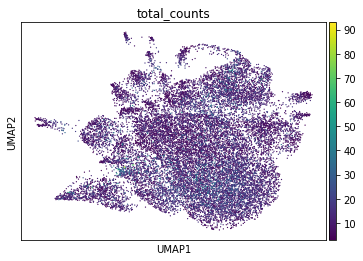

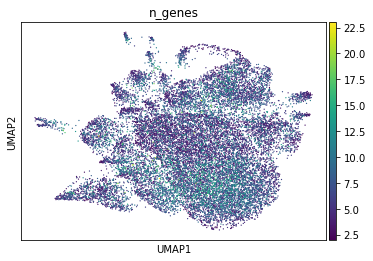

In [65]:
sc.pl.umap(cdata, color='leiden', legend_loc='on data')
sc.pl.umap(cdata, color='condition',)
sc.pl.umap(cdata, color='total_counts',)
sc.pl.umap(cdata, color='n_genes',)

<AxesSubplot:xlabel='leiden', ylabel='counts'>

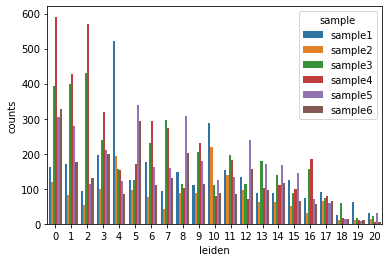

In [68]:
leiden_df = pd.DataFrame(cdata.obs.groupby('leiden')['sample'].value_counts().values)
leiden_df.columns = ['counts']
leiden_df['leiden'] = [i[0] for i in cdata.obs.groupby('leiden')['sample'].value_counts().index]
leiden_df['sample'] = [i[1] for i in cdata.obs.groupby('leiden')['sample'].value_counts().index]
leiden_df['sample'] = leiden_df['sample'].astype('category')
sns.barplot(x='leiden', y='counts', hue='sample', data=leiden_df)

<AxesSubplot:xlabel='leiden', ylabel='counts'>

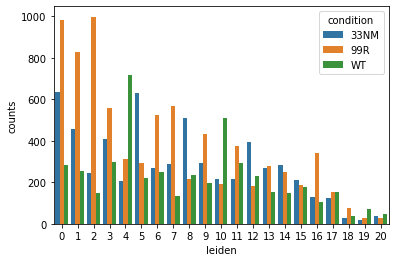

In [69]:
leiden_df = pd.DataFrame(cdata.obs.groupby('leiden')['condition'].value_counts().values)
leiden_df.columns = ['counts']
leiden_df['leiden'] = [i[0] for i in cdata.obs.groupby('leiden')['condition'].value_counts().index]
leiden_df['condition'] = [i[1] for i in cdata.obs.groupby('leiden')['condition'].value_counts().index]
leiden_df['condition'] = leiden_df['condition'].astype('category')
sns.barplot(x='leiden', y='counts', hue='condition', data=leiden_df)

In [72]:
# Add log layer
cdata.layers['log_raw'] = np.log1p(cdata.layers['raw'])
sc.pp.normalize_total(cdata, layer='log_raw')

# Find gene markers for each cluster
sc.tl.rank_genes_groups(cdata, 'leiden', method='wilcoxon', layer='log_raw', pts=False, use_raw=False, n_genes=cdata.shape[1])

# Filter markers
# sc.tl.filter_rank_genes_groups(cdata, min_fold_change=.1, min_in_group_fraction=0.2, max_out_group_fraction=0.8)

C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fra

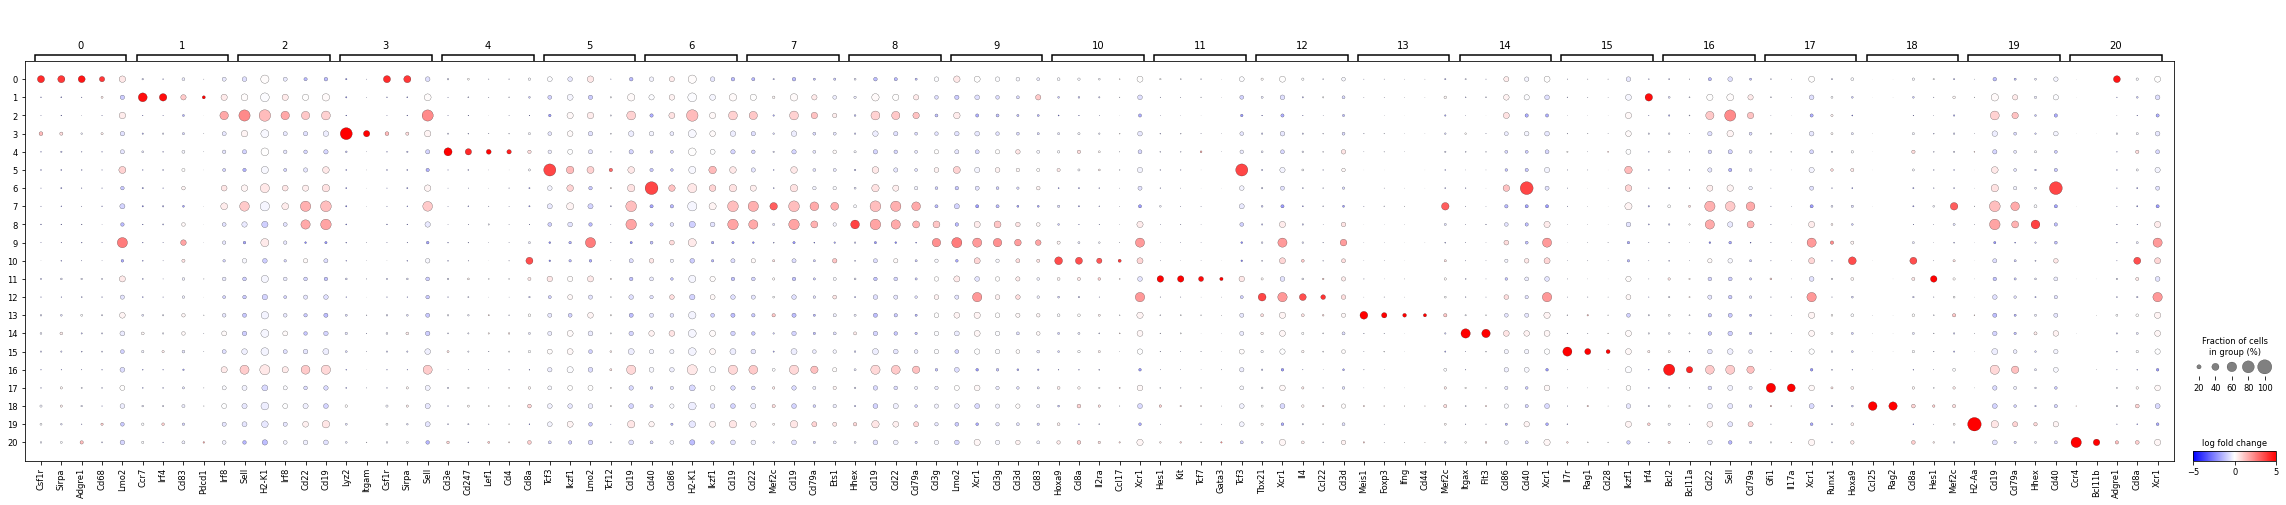

In [74]:
sc.pl.rank_genes_groups_dotplot(cdata, groupby='leiden', n_genes=5, values_to_plot='logfoldchanges', vmax=5, vmin=-5, cmap='bwr', dendrogram=False)

In [ ]:
# load gene annotation 
genes_df = pd.read_excel(os.path.join(base_path, 'documents', 'Spleen profiling genes_STARmap_corrected_64-genes.xlsx'))
markers_dict = {}
for current_category in genes_df['cell_type'].unique():
    markers_dict[current_category] = genes_df.loc[genes_df['cell_type'] == current_category, 'Gene Symbol'].values

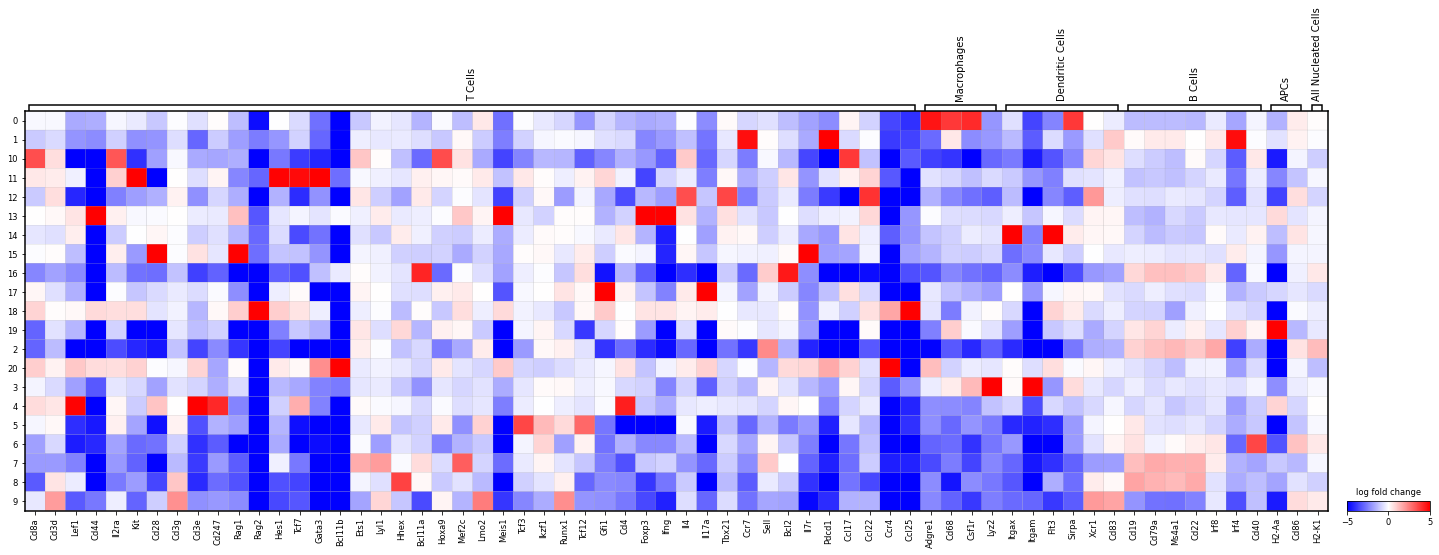

In [ ]:
# Dot plot logfoldchanges
sc.pl.rank_genes_groups_matrixplot(cdata, key='rank_genes_groups', var_names=markers_dict, 
                                values_to_plot='logfoldchanges', vmax=5, vmin=-5, cmap='bwr', 
                                dendrogram=False, swap_axes=False,) # save='level_2')

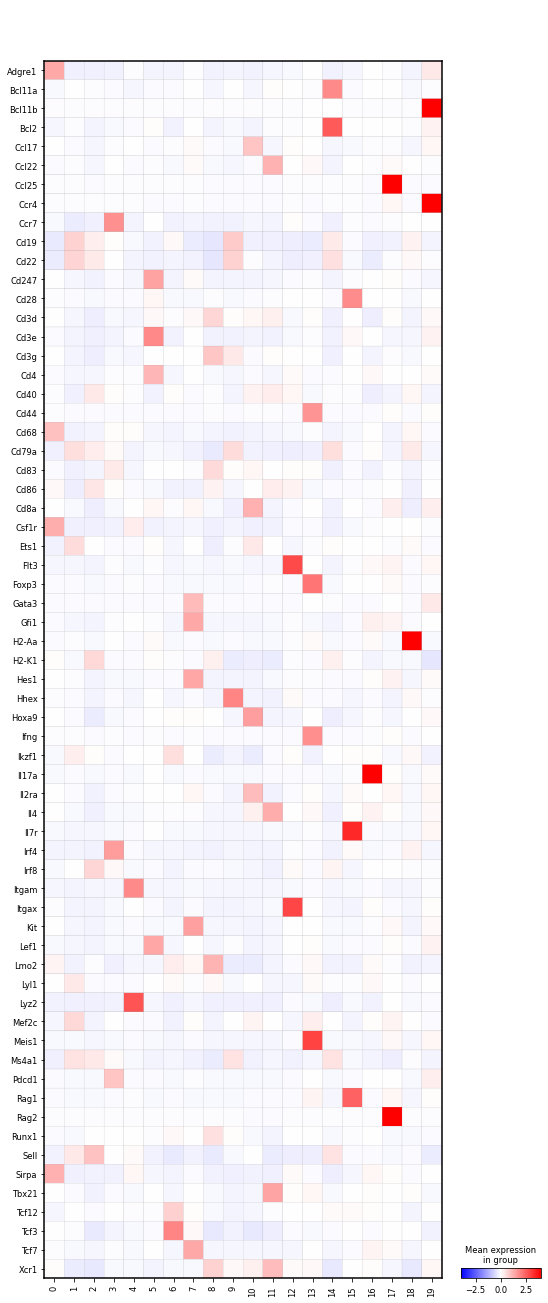

In [58]:
sc.pl.matrixplot(cdata, cdata.var.index, groupby=f'leiden', dendrogram=False, use_raw=False, cmap='bwr', vmin=-4, vmax=4, swap_axes=True)

### assign cell types

In [35]:
# create backup for leiden label
cdata.obs['orig_leiden'] = cdata.obs['leiden'].values

cdata.obs['level_1'] = cdata.obs['leiden'].values

In [36]:
# Change cluster label to cell type label
transfer_dict_l1 = {}

# Level_1
level_1_list = [
    'B cells', #0
    'T cells', #1
    'Macrophages', #2
    'T cells', #3
    'B cells', #4
    'Macrophages', #5
    'T cells', #6
    'T cells', #7
    'Dendritic cells', #8
    'T cells', #9
]

# construct transfer dict
for i in sorted(cdata.obs['leiden'].unique()):
    transfer_dict_l1[i] = level_1_list[int(i)]

In [37]:
# Assign cell type to sdata
cdata.obs = cdata.obs.replace({'level_1': transfer_dict_l1})

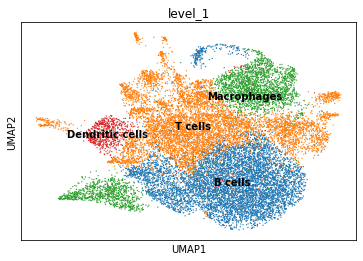

In [38]:
sc.pl.umap(cdata, color='level_1', legend_loc='on data')

<AxesSubplot:xlabel='level_1', ylabel='counts'>

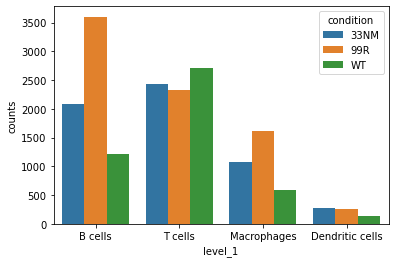

In [39]:
leiden_df = pd.DataFrame(cdata.obs.groupby('level_1')['condition'].value_counts().values)
leiden_df.columns = ['counts']
leiden_df['level_1'] = [i[0] for i in cdata.obs.groupby('level_1')['condition'].value_counts().index]
leiden_df['condition'] = [i[1] for i in cdata.obs.groupby('level_1')['condition'].value_counts().index]
leiden_df['condition'] = leiden_df['condition'].astype('category')
sns.barplot(x='level_1', y='counts', hue='condition', data=leiden_df)

## Level 2

In [87]:
# Subset
sub_id = 'T cells'
current_cells = cdata.obs['level_1'] == sub_id
sdata = cdata[current_cells, markers_dict['T Cells']].copy()
sdata

AnnData object with n_obs × n_vars = 7478 × 44
    obs: 'sample', 'fov_id', 'volume', 'fov_x', 'fov_y', 'fov_z', 'seg_label', 'global_x', 'global_y', 'global_z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'condition', 'leiden', 'orig_leiden', 'level_1', 'level_2_temp'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden', 'level_1_colors', 'level_2_temp_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'scaled', 'corrected', 'log_raw'
    obsp: 'distances', 'connectivities'

C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


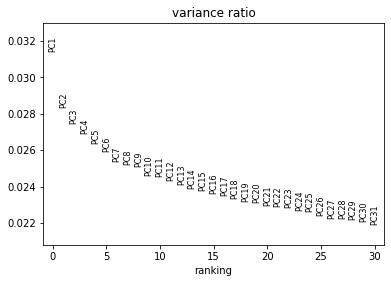

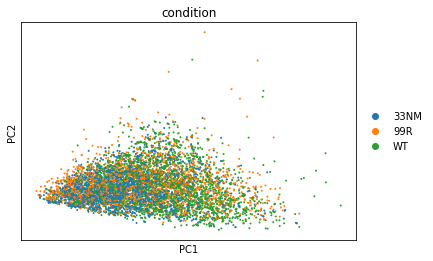

CPU times: total: 9.39 s
Wall time: 736 ms


In [88]:
%%time
# redo pp (test)
sdata.X = sdata.layers['raw'].copy()
del sdata.layers['scaled']
del sdata.layers['corrected']

sc.pp.normalize_total(sdata)
sc.pp.log1p(sdata)
sdata.raw = sdata
sc.pp.scale(sdata)
sdata.layers['scaled'] = sdata.X.copy()
sc.pp.regress_out(sdata, ['total_counts'])
sdata.layers['corrected'] = sdata.X.copy()

# Run PCA
sdata.X = sdata.layers['corrected'].copy()
sc.tl.pca(sdata, svd_solver='full')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Plot PCA
sc.pl.pca(sdata, color='condition')

In [101]:
# Embedding parameters
emb_dict = {
    'T cells': {'n_neighbors': 15, 'n_pcs': 30, 'min_dist': .1, 'cluster_resolution': .4},
    'B cells': {'n_neighbors': 50, 'n_pcs': 30, 'min_dist': .1, 'cluster_resolution': .5},
    'Macrophages': {'n_neighbors': 50, 'n_pcs': 30, 'min_dist': .1, 'cluster_resolution': .6},
     'Dendritic cells': {'n_neighbors': 50, 'n_pcs': 30, 'min_dist': .1, 'cluster_resolution': .6},
}

save_embedding = True

In [102]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
clustering_out_path = os.path.join(output_path, f'{date}-clustering')
if not os.path.exists(clustering_out_path):
    os.mkdir(clustering_out_path)
    
sub_level_fig_path = os.path.join(clustering_out_path, sub_id)
if not os.path.exists(sub_level_fig_path):
    os.mkdir(sub_level_fig_path)

### clustering

In [103]:
%%time
# Computing the neighborhood graph
n_neighbors = emb_dict[sub_id]['n_neighbors']
n_pcs = emb_dict[sub_id]['n_pcs']
min_dist = emb_dict[sub_id]['min_dist']

sc.pp.neighbors(sdata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=0)

# Run UMAP
min_dist = 0.1
spread = 3
sc.tl.umap(sdata, min_dist=min_dist, spread=spread)

CPU times: total: 27.8 s
Wall time: 14.4 s


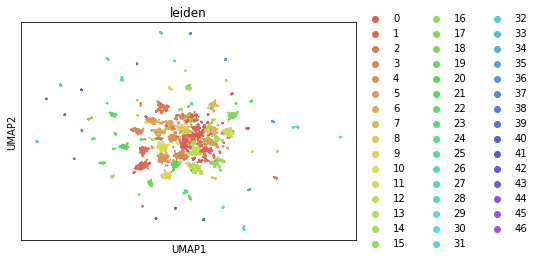

CPU times: total: 1.36 s
Wall time: 1.41 s


In [104]:
%%time
# Run leiden cluster
cluster_resolution = emb_dict[sub_id]['cluster_resolution']
sc.tl.leiden(sdata, resolution = cluster_resolution)

# Plot UMAP with cluster labels 
sc.pl.umap(sdata, color='leiden')
n_clusters = sdata.obs['leiden'].unique().shape[0]

if save_embedding:
    # Save log
    with open(f'{sub_level_fig_path}/log_{sub_id}.txt', 'w') as f:
        f.write(f"""Number of neighbor: {n_neighbors}
    Number of PC: {n_pcs}
    Resolution: {cluster_resolution}
    Min-distance: {min_dist}
    Number of clusters: {n_clusters}""")

    # save embeddings
    np.savetxt(f'{sub_level_fig_path}/embedding_{sub_id}_umap.csv', sdata.obsm['X_umap'], delimiter=",")

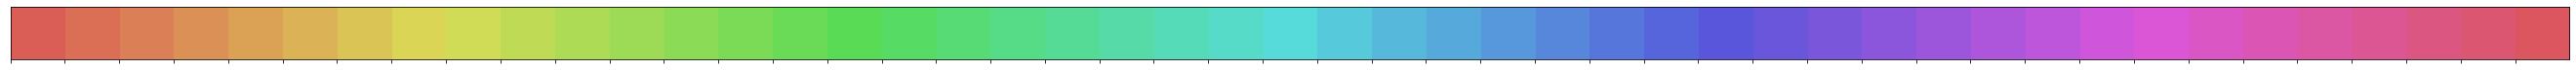

In [105]:
# Get colormap
cluster_pl = sns.color_palette("hls", n_clusters)
cluster_cmap = ListedColormap(cluster_pl.as_hex())
sns.palplot(cluster_pl)

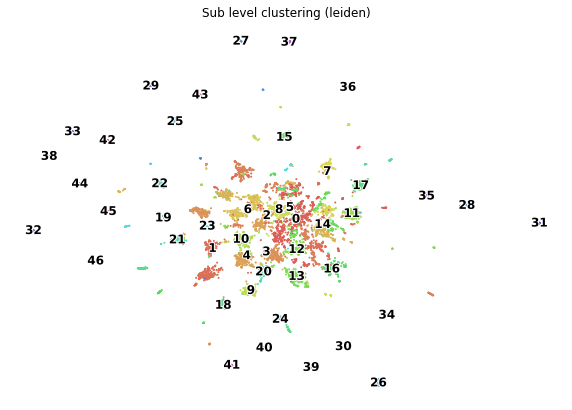

In [106]:
# Plot UMAP with cluster labels w/ new color
fig, ax = plt.subplots(figsize=(10,7))
sc.pl.umap(sdata, color='leiden', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Sub level clustering (leiden)', palette=cluster_pl, save=False, ax=ax)

In [79]:
# move label to level 2 and check
cdata.obs['level_2_temp'] = 'NA'
cdata.obs.loc[cdata.obs['level_1'] == sub_id, 'level_2_temp'] = sdata.obs.leiden.values
cdata.obs['level_2_temp'] = cdata.obs['level_2_temp'].astype('category')
temp_order = sdata.obs.leiden.cat.categories.to_list()
temp_order.append('NA')
cdata.obs['level_2_temp'] = cdata.obs['level_2_temp'].cat.reorder_categories(temp_order)
temp_pl = sns.color_palette(sdata.uns['leiden_colors'] + ['#ebebeb'])

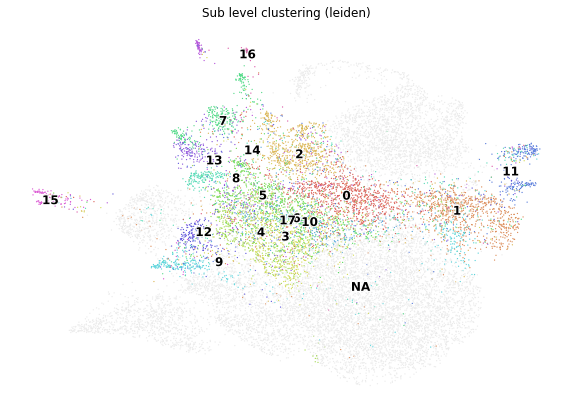

In [81]:
# Plot UMAP with all cell embedding
fig, ax = plt.subplots(figsize=(10,7))
sc.pl.umap(cdata, color='level_2_temp', legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=2, frameon=False, 
           title='Sub level clustering (leiden)', palette=temp_pl, save=False, ax=ax)

In [82]:
# Add log layer
# sdata.layers['log_raw'] = np.log1p(sdata.layers['raw'])
# sc.pp.normalize_total(sdata, layer='log_raw')
# sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon', layer='log_raw', pts=True, use_raw=False, n_genes=adata.shape[1])

# Find gene markers for each cluster
sc.tl.rank_genes_groups(sdata, 'leiden', method='wilcoxon', pts=True, use_raw=True, n_genes=cdata.shape[1])

# Filter markers
sc.tl.filter_rank_genes_groups(sdata, min_fold_change=.1, min_in_group_fraction=0.2, max_out_group_fraction=0.8)

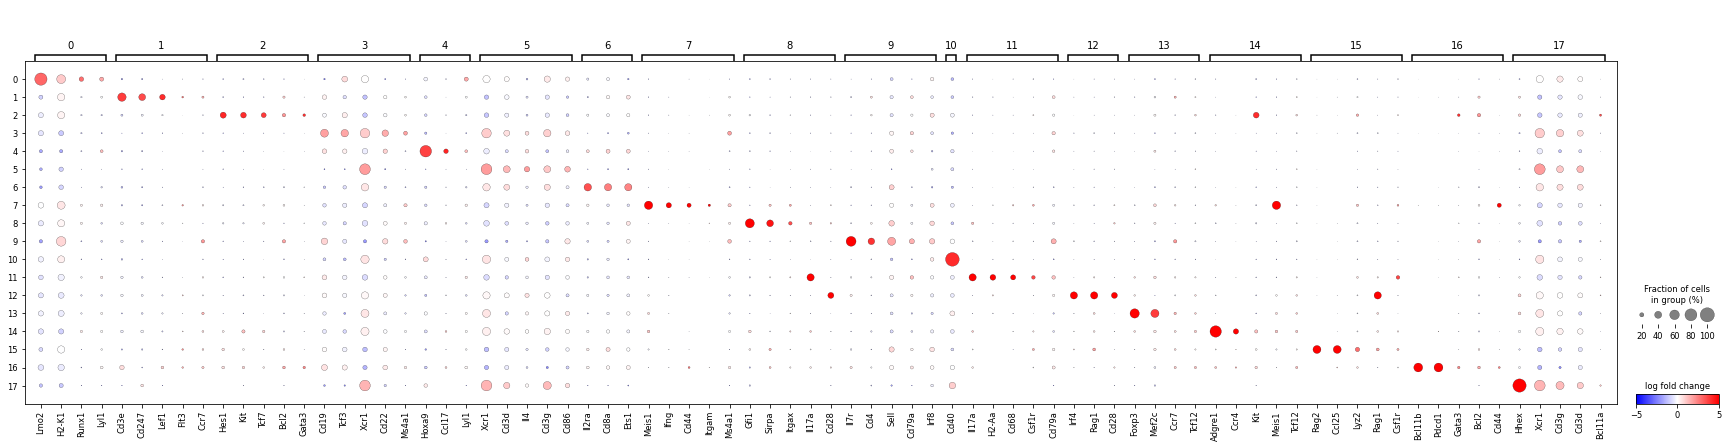

In [83]:
# Dot plot logfoldchanges
sc.pl.rank_genes_groups_dotplot(sdata, key='rank_genes_groups', n_genes=5, values_to_plot='logfoldchanges', min_logfoldchange=1, vmax=5, vmin=-5, cmap='bwr', dendrogram=False)

In [76]:
# Print markers 
markers = []
temp = pd.DataFrame(cdata.uns['rank_genes_groups']['names']).head(15)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers = markers + curr_col
    # print(i, curr_col)
    print(i)
    for j in curr_col:
        print(j, end=' ')
    print('')

0
Csf1r Sirpa Adgre1 Cd68 Lmo2 Cd86 Xcr1 H2-K1 Il4 Tcf3 Cd247 Hoxa9 Hes1 Cd3g Tbx21 
1
Ccr7 Irf4 Cd83 Pdcd1 Irf8 Cd79a Cd86 Ms4a1 Cd19 Sell Cd22 Cd40 Cd68 Mef2c H2-K1 
2
Sell H2-K1 Irf8 Cd22 Cd19 Ms4a1 Cd79a Cd86 Lmo2 Ikzf1 Ets1 Runx1 Lyl1 Bcl11b Tcf12 
3
Lyz2 Itgam Csf1r Sirpa Sell Cd68 Ikzf1 Runx1 Itgax Ccl17 Gfi1 Bcl11b Ccl25 Ccr4 Rag2 
4
Cd3e Cd247 Lef1 Cd4 Cd8a Cd3d Tcf7 Cd28 H2-Aa Il2ra Il7r Il17a Bcl2 Ets1 Gfi1 
5
Tcf3 Ikzf1 Lmo2 Tcf12 Cd19 Runx1 Hoxa9 Cd3g Lyl1 Il2ra Cd3d Ccl17 Bcl11b Il4 Cd83 
6
Cd40 Cd86 H2-K1 Ikzf1 Cd19 Irf8 Cd22 Sell Cd83 Ms4a1 Tcf12 Tcf3 Bcl11b Rag2 Ccr4 
7
Cd22 Mef2c Cd19 Cd79a Ets1 Sell Ms4a1 Lyl1 Irf8 Ikzf1 Bcl11a Bcl2 Hhex Hes1 H2-K1 
8
Hhex Cd19 Cd22 Cd79a Cd3g Ms4a1 Xcr1 Cd3d Cd83 Lef1 Runx1 Bcl11a Bcl11b Rag2 Ccr4 
9
Lmo2 Xcr1 Cd3g Cd3d Cd83 Runx1 H2-K1 Cd86 Lyl1 Hoxa9 Bcl11b Cd28 Il2ra Rag2 Ccr4 
10
Hoxa9 Cd8a Il2ra Ccl17 Xcr1 Ets1 Il4 Cd3d Cd40 Mef2c Cd83 Bcl11b Ccl25 Rag2 Ccr4 
11
Hes1 Kit Tcf7 Gata3 Tcf3 Lmo2 Il2ra Cd8a Cd3d Gfi1 Ccl22 Bcl2 Cd24

C:\Users\jiahao\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=30.
  warnings.warn(


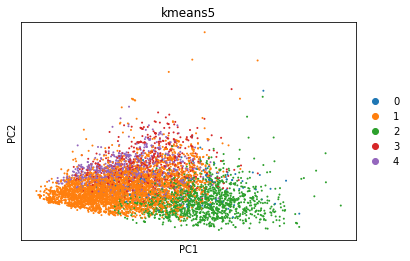

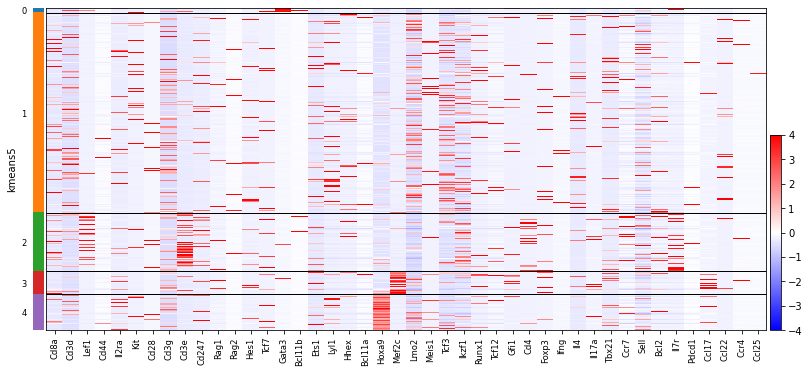

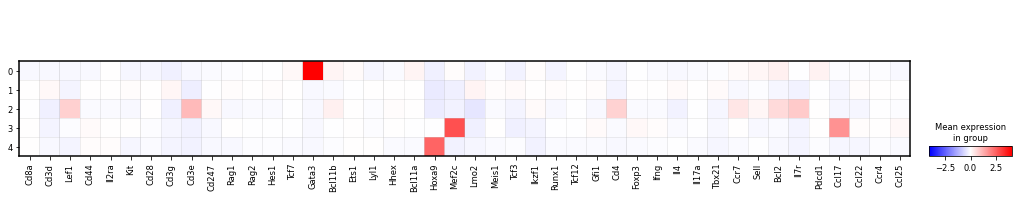

In [109]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Use PCA embedding
# extract pca coordinates
X_pca = sdata.obsm['X_pca']

# kmeans with k=8
k = 5
kmeans = KMeans(n_clusters=k, random_state=5).fit(X_pca)
sdata.obs[f'kmeans{k}'] = kmeans.labels_.astype(str)

sc.pl.pca(sdata, color=[f'kmeans{k}'])
sc.pl.heatmap(sdata, sdata.var.index, groupby=f'kmeans{k}', dendrogram=False, use_raw=False, cmap='bwr', vmin=-4, vmax=4)
sc.pl.matrixplot(sdata, sdata.var.index, groupby=f'kmeans{k}', dendrogram=False, use_raw=False, cmap='bwr', vmin=-4, vmax=4)

In [110]:
t_cell_genes = ['Cd3d', 'Cd8a', 'Cd4', 'Foxp3', 'Il2ra', 'Il4', 'Ifng', 'Il17a', 'Sell', 'Lef1', 'Ccr7']

In [111]:
# Subset
sub_id = 'T cells'
current_cells = cdata.obs['level_1'] == sub_id
sdata = cdata[current_cells, t_cell_genes].copy()
sdata

AnnData object with n_obs × n_vars = 7478 × 11
    obs: 'sample', 'fov_id', 'volume', 'fov_x', 'fov_y', 'fov_z', 'seg_label', 'global_x', 'global_y', 'global_z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'condition', 'leiden', 'orig_leiden', 'level_1', 'level_2_temp'
    var: 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'dendrogram_leiden', 'level_1_colors', 'level_2_temp_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'scaled', 'corrected', 'log_raw'
    obsp: 'distances', 'connectivities'

C:\Users\jiahao\.conda\envs\sc_38\lib\site-packages\scanpy\preprocessing\_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


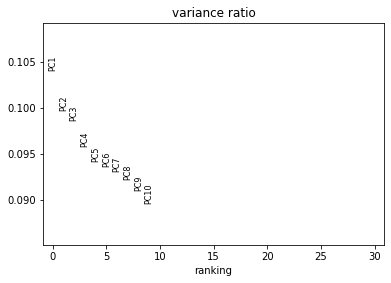

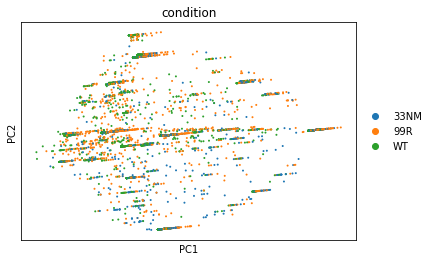

CPU times: total: 4.62 s
Wall time: 382 ms


In [112]:
%%time
# redo pp (test)
sdata.X = sdata.layers['raw'].copy()
del sdata.layers['scaled']
del sdata.layers['corrected']

sc.pp.normalize_total(sdata)
sc.pp.log1p(sdata)
sdata.raw = sdata
sc.pp.scale(sdata)
sdata.layers['scaled'] = sdata.X.copy()
sc.pp.regress_out(sdata, ['total_counts'])
sdata.layers['corrected'] = sdata.X.copy()

# Run PCA
sdata.X = sdata.layers['corrected'].copy()
sc.tl.pca(sdata, svd_solver='full')

# Plot explained variance 
sc.pl.pca_variance_ratio(sdata, log=False)

# Plot PCA
sc.pl.pca(sdata, color='condition')

C:\Users\jiahao\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=30.
  warnings.warn(


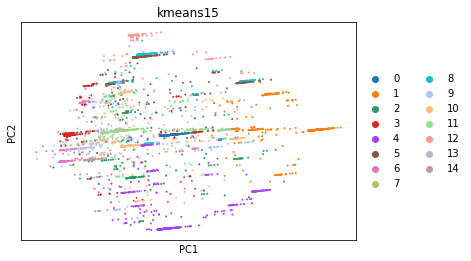

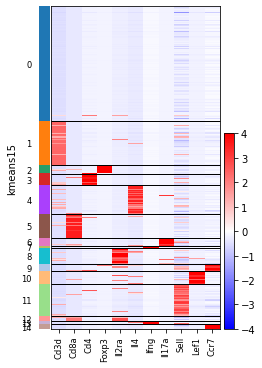

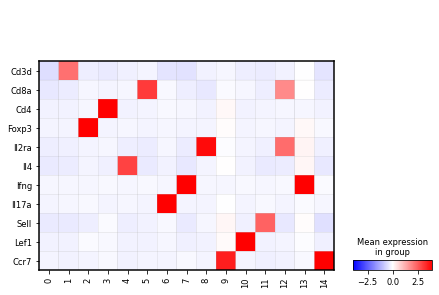

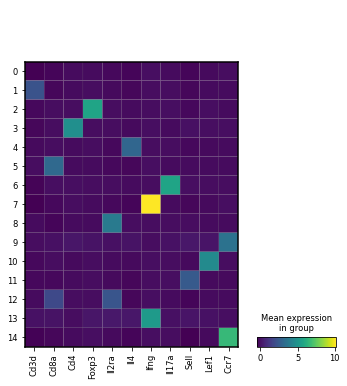

In [118]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Use PCA embedding
# extract pca coordinates
# X_pca = sdata.obsm['X_pca']
X_pca = sdata.X

# kmeans with k=8
k = 15
kmeans = KMeans(n_clusters=k, random_state=5).fit(X_pca)
sdata.obs[f'kmeans{k}'] = kmeans.labels_.astype(str)

sc.pl.pca(sdata, color=[f'kmeans{k}'])
sc.pl.heatmap(sdata, sdata.var.index, groupby=f'kmeans{k}', dendrogram=False, use_raw=False, cmap='bwr', vmin=-4, vmax=4)
sc.pl.matrixplot(sdata, sdata.var.index, groupby=f'kmeans{k}', dendrogram=False, use_raw=False, cmap='bwr', vmin=-4, vmax=4, swap_axes=True)
sc.pl.matrixplot(sdata, sdata.var.index, groupby=f'kmeans{k}', dendrogram=False, use_raw=False)

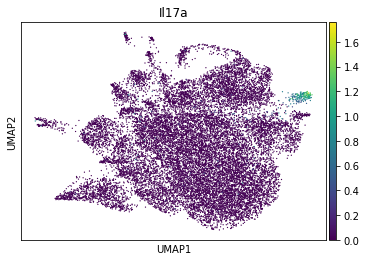

In [134]:
sc.pl.umap(cdata, color='Il17a')

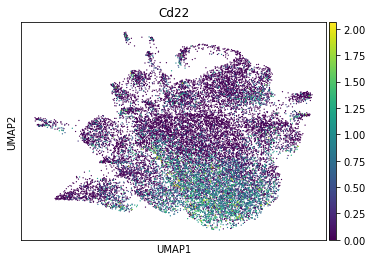

In [139]:
sc.pl.umap(cdata, color='Cd22')